<a href="https://colab.research.google.com/github/idc315/presentation-1-group-9/blob/main/Youtube_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade google-api-python-client
!pip install --upgrade google-auth-oauthlib google-auth-httplib2
!pip install isodate

/bin/bash: -c: line 1: syntax error near unexpected token `"install --upgrade google-api-python-client"'
/bin/bash: -c: line 1: `pip("install --upgrade google-api-python-client")'


In [ ]:
import pandas as pd
import numpy as np
import os

import google.oauth2.credentials
import google_auth_oauthlib.flow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from google_auth_oauthlib.flow import InstalledAppFlow
import isodate

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone
import calendar

from scipy import stats
client_id =
_client_secret =


In [ ]:
API_KEY =

youtube = build('youtube', 'v3', developerKey=API_KEY)

def convert_duration(duration):
    try:
        duration = isodate.parse_duration(duration)
        return duration.total_seconds()
    except isodate.ISO8601Error:
        return 0

def get_videos_by_category(category_id, max_results, region_code='JP'):
    video_data = []
    next_page_token = None
    count = 0

    while count < max_results:
        response = youtube.search().list(
            part='snippet',
            type='video',
            videoCategoryId=category_id,
            maxResults=50,
            regionCode=region_code,
            pageToken=next_page_token
        ).execute()

        for item in response['items']:
            video_id = item['id']['videoId']
            video_info = youtube.videos().list(
                part='snippet,contentDetails,statistics',
                id=video_id
            ).execute()

            for video in video_info['items']:
                title = video['snippet']['title']
                upload_date = video['snippet']['publishedAt']
                views = video['statistics'].get('viewCount', 0) if 'statistics' in video else 0
                duration = video['contentDetails']['duration']
                length_seconds = convert_duration(duration)

                video_data.append({
                    'title': title,
                    'upload_date': upload_date,
                    'views': views,
                    'length_seconds': length_seconds
                })

                count += 1
                if count >= max_results:
                    break

        next_page_token = response.get('nextPageToken')

        if not next_page_token:
            break

    return video_data


category_id = '10'
video_data = get_videos_by_category(category_id, max_results=1000)

for video in video_data:
    print(f"Title: {video['title']}")
    print(f"Upload Date: {video['upload_date']}")
    print(f"Views: {video['views']}")
    print(f"Length (seconds): {video['length_seconds']}")
    print('-' * 50)


Title: Aimer「残響散歌」MUSIC VIDEO（テレビアニメ「鬼滅の刃」遊郭編オープニングテーマ）
Upload Date: 2021-12-12T15:00:11Z
Views: 234016217
Length (seconds): 182.0
--------------------------------------------------
Title: King & Prince「ツキヨミ」MV YouTube Edit
Upload Date: 2022-10-11T11:00:10Z
Views: 173899103
Length (seconds): 163.0
--------------------------------------------------
Title: TWICE 「Celebrate」 Music Video
Upload Date: 2022-07-14T15:00:32Z
Views: 79196663
Length (seconds): 186.0
--------------------------------------------------
Title: TXT(투모로우바이투게더) ‘Magic’ Special Performance Video
Upload Date: 2021-06-30T10:00:00Z
Views: 24705655
Length (seconds): 167.0
--------------------------------------------------
Title: Westlife - The Rose (Official Video)
Upload Date: 2009-10-03T19:51:58Z
Views: 33202620
Length (seconds): 213.0
--------------------------------------------------
Title: ルパン三世のテーマ'80 - You & Explosion Band | 大野雄二ベスト・ヒット・ライブ 2022.01.28 at 東京国際フォーラム ホールA
Upload Date: 2022-05-30T11:00:18Z
Views: 7848952

In [ ]:
df = pd.DataFrame(video_data)
df['views'] = pd.to_numeric(df['views'], errors='coerce')
df_sorted = df.sort_values(by=['views'], ascending=False)
df_sorted

,title,upload_date,views,length_seconds
38,米津玄師 Kenshi Yonezu - Lemon,2018-02-26T23:00:04Z,885632999,275.0
179,DAOKO × 米津玄師『打上花火』MUSIC VIDEO,2017-08-09T15:01:26Z,634199871,293.0
67,DAOKO × 米津玄師『打上花火』MUSIC VIDEO,2017-08-09T15:01:26Z,634199871,293.0
134,YOASOBI「アイドル」 Official Music Video,2023-04-12T15:30:09Z,537167832,226.0
113,Official髭男dism - Pretender［Official Video］,2019-04-16T13:58:12Z,532564364,336.0
...,...,...,...,...
561,[QWER] 시요밍이 서럽게 울었던 이유..,2024-10-13T11:47:16Z,47964,60.0
514,That moment I LOST MY WIG on stage in front of...,2024-10-13T15:14:37Z,43281,4057.0
388,"Xdinary Heroes(엑스디너리 히어로즈) ""Night before the e...",2024-10-13T02:59:55Z,43210,37.0
490,Battle Pro - Finals - Théâtre du Châtelet – AR...,2024-10-13T16:47:10Z,9044,9326.0


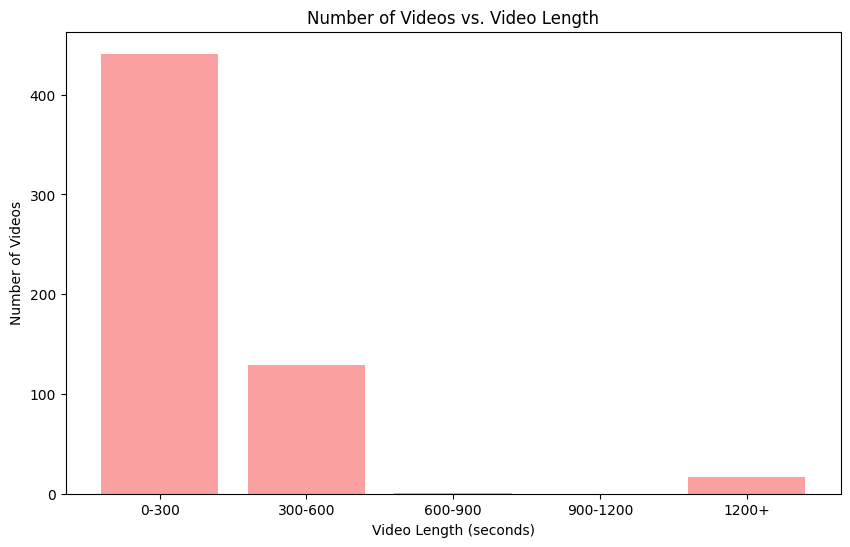

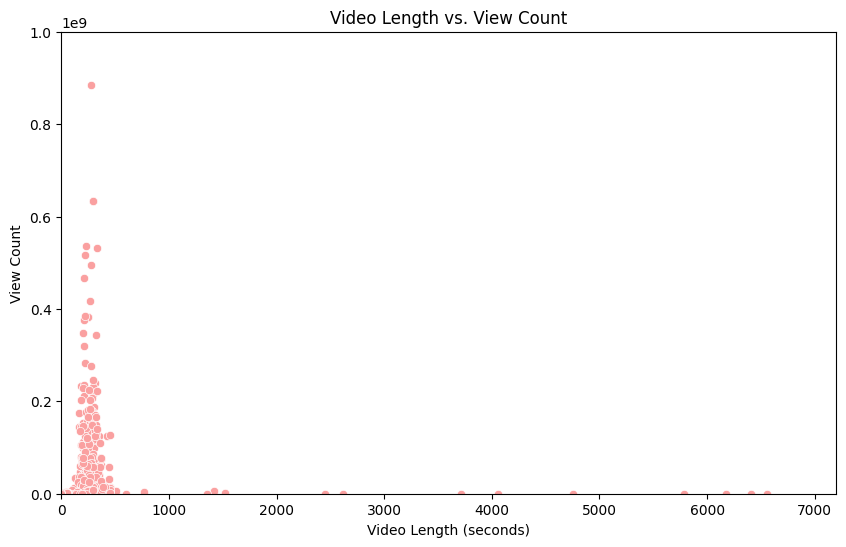


Correlation between video length and view count: -0.0620685679004412


In [ ]:
df['views'] = pd.to_numeric(df['views'])

bins = [0, 300, 600, 900, 1200, float('inf')]
labels = ['0-300', '300-600', '600-900', '900-1200', '1200+']
df['length_bin'] = pd.cut(df['length_seconds'], bins=bins, labels=labels)

video_counts = df['length_bin'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(video_counts.index, video_counts.values, color='#FAA0A0')
plt.title('Number of Videos vs. Video Length')
plt.xlabel('Video Length (seconds)')
plt.ylabel('Number of Videos')
plt.show()

print()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='length_seconds', y='views', data=df, color='#FAA0A0')
plt.title('Video Length vs. View Count')
plt.xlabel('Video Length (seconds)')
plt.ylabel('View Count')
plt.ylim(0, 1000000000)
plt.xlim(0, 7200)
plt.show()

correlation = df['length_seconds'].corr(df['views'])
print()
print(f"Correlation between video length and view count: {correlation}")


In [45]:
longer_vid = df[df['length_seconds'] > 600]['views']

shorter_vid = df[df['length_seconds'] <= 600]['views']

t_statistic, p_value = stats.ttest_ind(shorter_vid, longer_vid,alternative='greater')

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Null hypothesis: There is no relation between runtime and revenue
# Alternative hypothesis: Longer movies have higher revenue
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is evidence to suggest that videos under 10 minutes receive more views compared to other video.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that videos under 10 minutes receive more views compared to other video.")

T-statistic: 2.3039594860225674
P-value: 0.010783430020289326
Reject the null hypothesis.
There is evidence to suggest that videos under 10 minutes receive more views compared to other video.


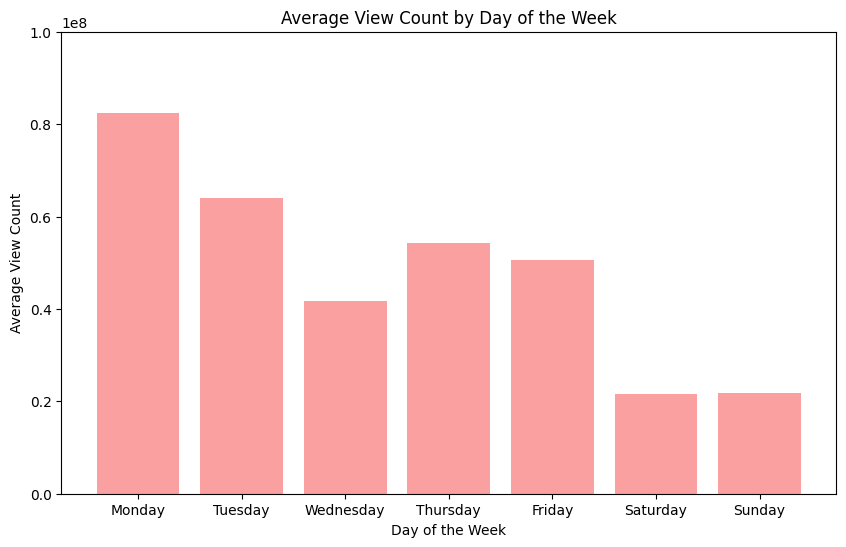

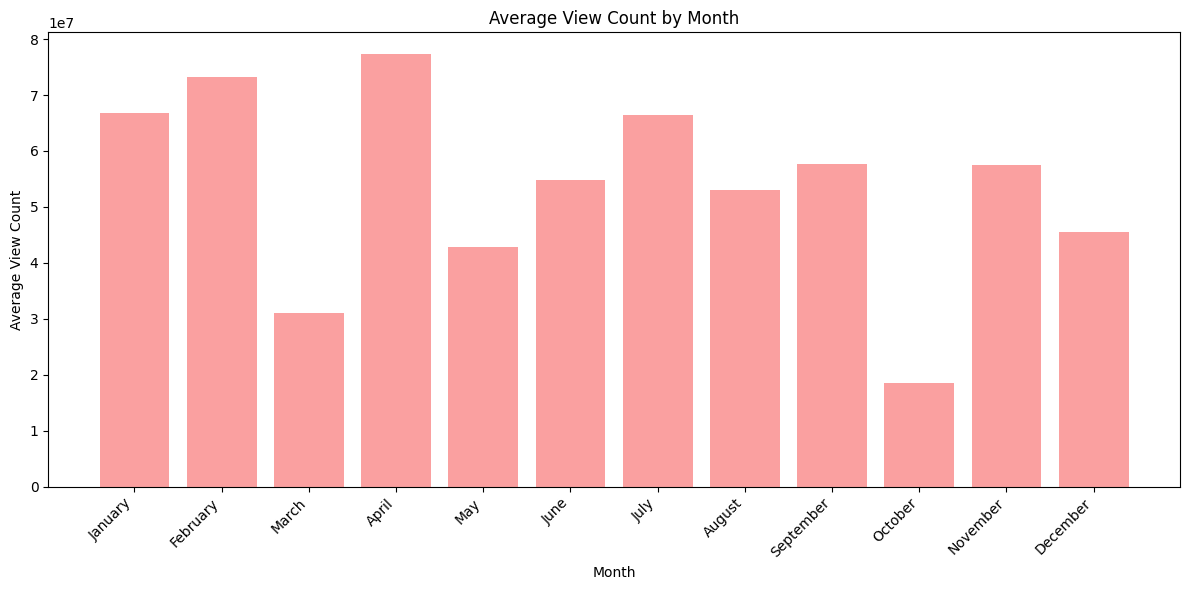

In [34]:
df['upload_date'] = pd.to_datetime(df['upload_date'], utc=True)
df['day_of_week'] = df['upload_date'].dt.dayofweek
df['month'] = df['upload_date'].dt.month
average_views_by_day = df.groupby('day_of_week')['views'].mean()
average_views_by_month = df.groupby('month')['views'].mean()

day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
month_names = [calendar.month_name[i] for i in range(1, 13)]

plt.figure(figsize=(10, 6))
plt.bar(average_views_by_day.index, average_views_by_day.values, color='#FAA0A0')
plt.title('Average View Count by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average View Count')
plt.ylim(0, 100000000)
plt.xticks(average_views_by_day.index, day_names)
plt.show()

print()

plt.figure(figsize=(12, 6))
plt.bar(average_views_by_month.index, average_views_by_month.values, color='#FAA0A0')
plt.title('Average View Count by Month')
plt.xlabel('Month')
plt.ylabel('Average View Count')
plt.xticks(average_views_by_month.index, month_names, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
weekend_df = df[(df['day_of_week'] == 5) | (df['day_of_week'] == 6)]
weekday_df = df[(df['day_of_week'] != 5) & (df['day_of_week'] != 6)]

weekend_views = weekend_df['views']
weekday_views = weekday_df['views']


t_statistic, p_value = stats.ttest_ind(weekend_views, weekday_views,alternative='greater')

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")


alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is evidence to suggest that videos under 10 minutes receive more views compared to other video.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that videos under 10 minutes receive more views compared to other video.")

T-statistic: -4.34297757867215
P-value: 0.999991744818213
Fail to reject the null hypothesis.
There is not enough evidence to suggest that videos under 10 minutes receive more views compared to other video.


In [44]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['season'] = df['month'].apply(get_season)
summer_view = df[df['season'] == 'Summer']['views']
others_view = df[df['season'] != 'Summer']['views']

t_statistic, p_value = stats.ttest_ind(summer_view, others_view,alternative='greater')

print(f"T-statistic: {t_statistic}")
print(f"P-value: {p_value}")

# Null hypothesis: There is no relation between date of release and view count
# Alternative hypothesis: Longer movies have higher revenue
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is evidence to suggest that Videos are released when people have more leisure time (weekends and summer) have higher views than other times in the year. .")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not enough evidence to suggest that Videos are released when people have more leisure time (weekends and summer) have higher views than other times in the year. ")




T-statistic: 1.837596842468799
P-value: 0.03330889090742994
Reject the null hypothesis.
There is evidence to suggest that Videos are released when people have more leisure time (weekends and summer) have higher views than other times in the year. .


In [40]:
df.length_seconds.isnull().sum()


0